In [40]:
import pandas as pd
import numpy as np

In [41]:
df = pd.read_csv('infected_Data.csv')
df = df.drop(columns = ['ID'])
df.head()

,Fever,Cough,Breathing Issues,Infected
0,N,N,N,N
1,Y,Y,Y,Y
2,Y,Y,N,N
3,Y,N,Y,Y
4,Y,Y,Y,Y


In [42]:
def entropy(column):
    value, counts = np.unique(column, return_counts=True)
    value_counts = counts / counts.sum()
    entropy = -sum(value_counts * np.log2(value_counts + 1e-8))
    # print(entropy)
    return entropy
entropy(df['Infected'])

np.float64(0.9852281071803508)

In [43]:
def info_gain(d,a,t):
    e=entropy(d[t])
    v,c=np.unique(d[a],return_counts=True)
    return e-np.sum([c[i]/np.sum(c)*entropy(d[d[a]==v[i]][t]) for i in range(len(v))])
print([info_gain(df,x,df.columns[-1]) for x in df.columns[:-1]])


[np.float64(0.1280852788913942), np.float64(0.0391486719030707), np.float64(0.3960388449280442)]


In [44]:
def build_tree(data, attributes, target):
    # 1 attr
    if data[target].nunique()==1:
        return data[target].iat[0]
    # 2 no attr left
    if len(attributes)==0:
        return data[target].mode().iat[0]
    gains=[info_gain(data,a,target) for a in attributes]
    print(gains)
    best=attributes[np.argmax(gains)]
    tree={best:{}}
    for val,subset in data.groupby(best):
        tree[best][val]=build_tree(subset, [a for a in attributes if a!=best], target)
    return tree
tree=build_tree(df,df.columns[:-1],df.columns[-1])

[np.float64(0.1280852788913942), np.float64(0.0391486719030707), np.float64(0.3960388449280442)]
[np.float64(0.1908744974076345), np.float64(0.04841567350439391)]
[np.float64(0.0)]
[np.float64(0.19920349641231927), np.float64(0.0923593784848889)]
[np.float64(0.0)]


In [45]:
def print_tree(tree, indent=""):
    if not isinstance(tree, dict):
        print(indent + "-> " + str(tree))
        return
    for attr, branches in tree.items():
        print(indent + attr + "?")
        for val, sub in branches.items():
            print(indent + f"|--{val}")
            print_tree(sub, indent + "  ")
print_tree(tree)

Breathing Issues?
|--N
  Fever?
  |--N
    -> N
  |--Y
    Cough?
    |--Y
      -> N
|--Y
  Fever?
  |--N
    Cough?
    |--Y
      -> Y
  |--Y
    -> Y


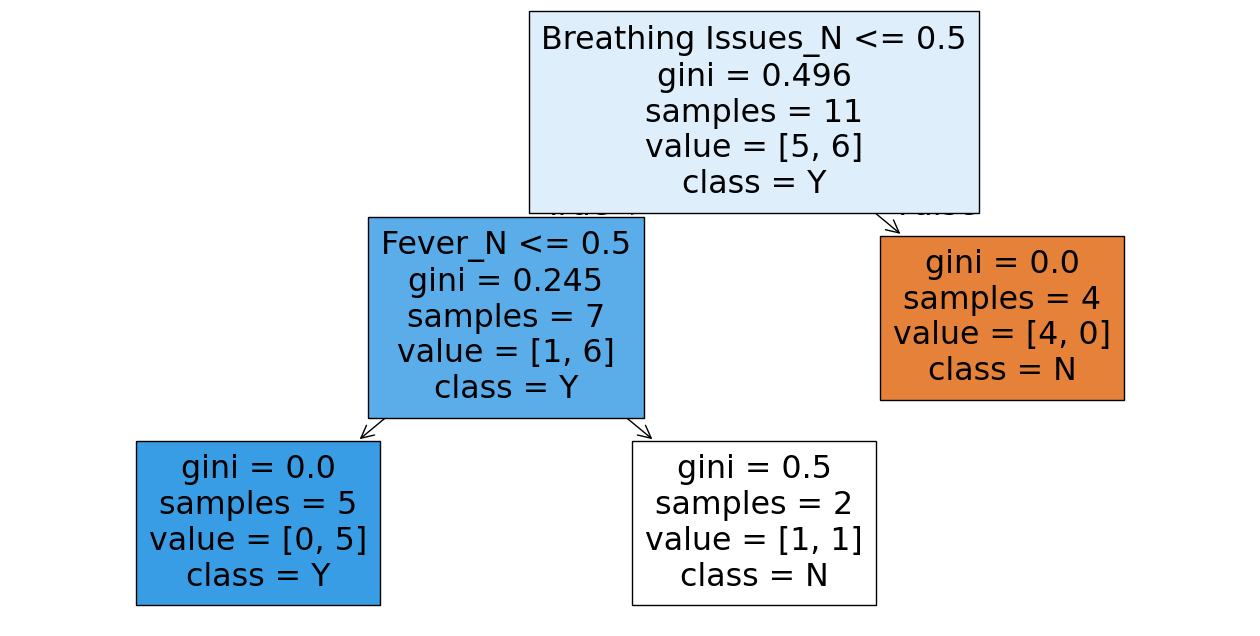

In [46]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'Infected' in categorical_cols:
    categorical_cols.remove('Infected')
df_encoded = pd.get_dummies(df, columns=categorical_cols)

features = [col for col in df_encoded.columns if col != 'Infected']
X = df_encoded[features]
y = df_encoded['Infected']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

plt.figure(figsize=(16,8))
plot_tree(dt, feature_names=features, class_names=[str(cls) for cls in dt.classes_], filled=True)
plt.show()